In [13]:
import math
import os
import torch
import torchvision.utils as vutils
from evolution.generator import Generator
from evolution.gan_train import GanTrain
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import glob
from datetime import datetime
from graphviz import Digraph
import json
import time
from IPython import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
from ipywidgets import widgets
import seaborn as sns
import matplotlib.ticker as ticker
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING)

## Visualizing Experiments

In [14]:
generations_dir, global_data, run_dir = None, None, None
def load_data():
    global generations_dir, global_data, run_dir
    all_runs = list(filter(os.path.isdir, glob.glob('runs/*')))
    all_runs.sort(key=os.path.getmtime)
    run_dir = all_runs[-1]
    print(run_dir)
    generations_dir = os.path.join(run_dir, "generations")
    global_data = pd.read_csv(os.path.join(generations_dir, "data.csv"), index_col=0)

load_data()

runs\Jan30_20-03-35_LAPTOP-T0BS8KBE


In [15]:
global_data.describe()

,species_d,speciation_threshold_d,invalid_d,species_g,speciation_threshold_g,invalid_g
count,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.0,1.0,0.0,1.0,1.0,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,1.0,1.0,0.0,1.0,1.0,0.0
25%,1.0,1.0,0.0,1.0,1.0,0.0
50%,1.0,1.0,0.0,1.0,1.0,0.0
75%,1.0,1.0,0.0,1.0,1.0,0.0
max,1.0,1.0,0.0,1.0,1.0,0.0


In [16]:
def load_generations_data(path):
    generation_dirs =  [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    generations_data = []
    for data_dir in sorted(generation_dirs):
        data_g = pd.read_csv(os.path.join(path, data_dir, "data_g.csv"), index_col=0)
        data_d = pd.read_csv(os.path.join(path, data_dir, "data_d.csv"), index_col=0)
        data = pd.concat([data_g.add_suffix("_g"), data_d.add_suffix("_d")], axis=1)
        generations_data.append(data)
    return generations_data

generations_data = load_generations_data(generations_dir)
generations_data[0].describe()
print(generations_data[-1].columns)
generations_data[-1].head()

Index(['loss_g', 'trained_samples_g', 'layers_g', 'genes_used_g', 'model_g',
       'species_index_g', 'fitness_g', 'generation_g', 'age_g', 'fid_score_g',
       'inception_score_g', 'rmse_score_g', 'loss_d', 'trained_samples_d',
       'layers_d', 'genes_used_d', 'model_d', 'species_index_d', 'fitness_d',
       'generation_d', 'age_d'],
      dtype='object')


,loss_g,trained_samples_g,layers_g,genes_used_g,model_g,species_index_g,fitness_g,generation_g,age_g,fid_score_g,...,rmse_score_g,loss_d,trained_samples_d,layers_d,genes_used_d,model_d,species_index_d,fitness_d,generation_d,age_d
0,3.086322,12800,1,200.0,"[{""type"": ""Linear"", ""wscale"": false, ""minibatc...",0,295.164042,0,0,295.164042,...,0.640855,0.109128,12800,1,200.0,"[{""type"": ""Conv2d"", ""wscale"": false, ""minibatc...",0,0.109128,0,0
1,2.358532,12800,1,200.0,"[{""type"": ""Linear"", ""wscale"": false, ""minibatc...",0,297.663823,0,0,297.663823,...,0.747326,0.214531,12800,1,200.0,"[{""type"": ""Conv2d"", ""wscale"": false, ""minibatc...",0,0.214531,0,0
2,2.423021,12800,1,200.0,"[{""type"": ""Linear"", ""wscale"": false, ""minibatc...",0,301.366836,0,0,301.366836,...,0.573312,0.293942,12800,1,200.0,"[{""type"": ""Conv2d"", ""wscale"": false, ""minibatc...",0,0.293942,0,0
3,2.595023,12800,1,200.0,"[{""type"": ""Linear"", ""wscale"": false, ""minibatc...",0,308.094309,0,0,308.094309,...,0.752986,0.308440,12800,1,200.0,"[{""type"": ""Conv2d"", ""wscale"": false, ""minibatc...",0,0.308440,0,0
4,3.420663,12800,1,200.0,"[{""type"": ""Linear"", ""wscale"": false, ""minibatc...",0,309.599502,0,0,309.599502,...,0.739371,0.546368,12800,1,200.0,"[{""type"": ""Conv2d"", ""wscale"": false, ""minibatc...",0,0.546368,0,0


In [17]:
def plot_loss(generations_data, points=None, show_generator=False, ax=None):
    df = pd.concat([pd.DataFrame(data={"loss": data["loss_d"], "generation": i, "type": "Discriminator"}) for i, data in enumerate(generations_data)])
    if show_generator:
        df = df.append(pd.concat([pd.DataFrame(data={"loss": data["loss_g"], "generation": i, "type": "Generator"}) for i, data in enumerate(generations_data)]))
    sns.lineplot(x="generation", y="loss", hue="type", data=df, ax=ax, estimator="min", ci=95)
    if points:
        for i, point in enumerate(points):
            ax.plot(point[0], point[1], marker='o', markersize=3, color=["blue", "red"][i])
            if not show_generator:
                break

def plot_fitness(generations_data, column, points=None, ax=None, estimator="min"):
    df = pd.concat([pd.DataFrame(data={column: data[column], "generation": i}) for i, data in enumerate(generations_data)])
    sns.lineplot(x="generation", y=column, data=df, ax=ax, estimator=estimator, ci=95)
    if points:
        for i, point in enumerate(points):
            ax.plot(point[0], point[1], marker='o', markersize=3, color=["blue", "red"][i])

def plot_model(json_str):
    dot = Digraph()
    dot.attr('node', shape='box')
    layers = json.loads(json_str)
    allowed_attrs = ["activation_type", "out_features", "in_features", "in_channels", "out_channels", "kernel_size", "stride"]
    for i, layer in enumerate(layers, 1):
        attributes = "<br/>".join([str(k) + ": " + str(v) for k, v in layer.items() if k in allowed_attrs])
        style_attrs = {}
        if i == len(layers):
            style_attrs = {'fillcolor': 'lightgray', 'style': 'filled'}
        dot.node(str(i), "<<b>"+ layer['type'] + "</b><br/>" + attributes + ">", **style_attrs)
        if i>1:
            dot.edge(str(i-1), str(i), constraint='false')
    dot.format = 'pdf'
    return dot

def select_generation(generation=len(generations_data)-1, individual=0, generations_data=None):
    data = generations_data[generation]
    g_index = min(individual, data["model_g"].count()-1)
    d_index = min(individual, data["model_d"].count()-1)
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30, 4))
    plot_fitness(generations_data, "fitness_g", points=[(generation, data["fitness_g"][g_index])], ax=axes[0])
    plot_fitness(generations_data, "fitness_d", points=[(generation, data["fitness_d"][d_index])], ax=axes[1])
    plot_fitness(generations_data, "fid_score_g", points=[(generation, data["fid_score_g"][g_index])], ax=axes[2])
    plot_fitness(generations_data, "inception_score_g", points=[(generation, data["inception_score_g"][g_index])], ax=axes[3], estimator="max")
    plot_fitness(generations_data, "rmse_score_g", points=[(generation, data["rmse_score_g"][g_index])], ax=axes[4])
    plot_loss(generations_data, points=[(generation, data["loss_d"][d_index]), (generation, data["loss_g"][g_index])], show_generator=True, ax=axes[5])
    plt.show()
    print(f"loss D: {data['loss_d'][d_index]:.2f}; fitness D: {data['fitness_d'][d_index]:.2f} species_index: {data['species_index_d'][d_index]}")
    d_model = plot_model(data["model_d"][d_index])
    d_model.render("runs/discriminator.gv")
    display.display(d_model)
    print(f"loss G: {data['loss_g'][g_index]:.2f}; fitness G: {data['fitness_g'][g_index]:.2f};",
          f"fid: {data['fid_score_g'][g_index]:.2f};",
          f"inception: {data['inception_score_g'][g_index]:.2f};",
          f"best fid: {data['fid_score_g'].min():.2f};",
          f"best inception: {data['inception_score_g'].min():.2f};",
          "species_index: ", data['species_index_g'][g_index])
    g_model = plot_model(data["model_g"][g_index])
    g_model.render("runs/generator.gv")
    display.display(g_model)
    plt.imshow(mpimg.imread(os.path.join(generations_dir, "{:03d}".format(generation), "images", "generator-{:03d}.png".format(g_index))))

def update():
    generations_data = load_generations_data(generations_dir)
    interactive_plot = interactive(select_generation, generation=IntSlider(min=0, max=len(generations_data)-1, value=len(generations_data)-1),
             individual=(0, len(generations_data[0])-1), generations_data=fixed(generations_data));
    interactive_plot.children[-1].layout.height = '1050px'
    return interactive_plot

interact_manual(load_data, manual_name='Reload Data')
interact_manual(update, manual_name='Update Charts');

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [18]:
noise = Generator().generate_noise(48, volatile=True).cpu()

runs\Jan30_20-03-35_LAPTOP-T0BS8KBE\generations\000\generator.pkl


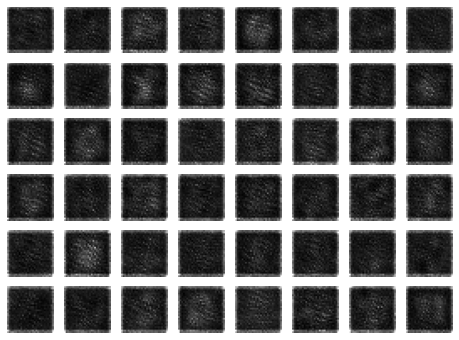

In [19]:
saved_models = sorted(glob.glob(os.path.join(generations_dir, "**", "generator.pkl")))
last_model = saved_models[-1]
print(last_model)
best_generator = Generator.load(last_model)
gen_images = best_generator(noise)

show_noise = 0
cols = 8
rows = math.ceil(len(gen_images) * (1 + show_noise) / cols)
f, axarr = plt.subplots(rows, cols, figsize=(cols, rows), gridspec_kw={'width_ratios': [3, 3] * (cols//2)})
count = 0
for i in range(len(gen_images)):
    if show_noise:
        axarr[count//cols, count%cols].imshow(noise[i][0].cpu().data.numpy(), cmap='gray')
        axarr[count//cols, count%cols].axis('off')
        count += 1
    img = np.transpose((gen_images[i].cpu().data.numpy() + 1)/2, (1, 2, 0))
    cmap = None
    if img.shape[2] == 1:
        img = np.squeeze(img)
        cmap = "gray"
    axarr[count//cols, count%cols].imshow(img, cmap=cmap)
    axarr[count//cols, count%cols].axis('off')
    count += 1
plt.savefig("runs/fashionmnist_samples.pdf")

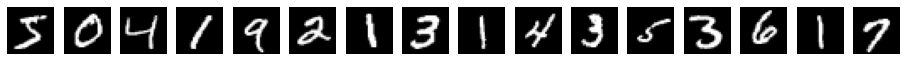

In [20]:
dataset = GanTrain.create_dataset()
dataset.transform = None
cols = 16
f, axarr = plt.subplots(1, cols, figsize=(cols, 10))
for i in range(cols):
    axarr[i].axis('off')
    axarr[i].imshow(dataset[i][0].convert('RGBA'))
gan_train = None

In [21]:
def merge_results(runs, column, ylabel="", fn="min", only_best=False, new_figure=True, save=True, color=None, legend=None, prefix="mnist", linestyle="--"):
    data = [[getattr(np, fn)(generations_data[i][column]) for generations_data in runs] for i in range(len(runs[0]))]
    print(column, data[-1])
    if only_best:
        data = [[generations_data[i][column][0] for generations_data in runs] for i in range(len(runs[0]))]

    if new_figure: plt.figure()
    sns.set(font_scale=1.2)
    sns.set_style("white")
    ax = sns.tsplot(np.array(data).T, ci=95, color=color, err_style=["ci_band"])#, "unit_traces"])
    sns.despine()
    ax.lines[-1].set_linestyle(linestyle)
    if legend: ax.legend(handles=ax.lines, labels=legend)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set(xlabel='generation', ylabel=ylabel or column)
    if save: ax.figure.savefig(os.path.join("runs", f"{prefix}_{column}.pdf".format(column=column)), bbox_inches='tight')
    return ax

# mnist
prefix = "mnist"
paths = [run_dir.split("/")[1]]
paths_random = [run_dir.split("/")[1]]
paths_dcgan = [run_dir.split("/")[1]]

linestyles = ["-", ":", "--"]

results = [load_generations_data(os.path.join("runs", path, "generations")) for path in paths]
results_random = [load_generations_data(os.path.join("runs", path, "generations")) for path in paths_random]
results_dcgan = [load_generations_data(os.path.join("runs", path, "generations")) for path in paths_dcgan]
merge_results(results, "fid_score_g", "FID", save=False, prefix=prefix, linestyle=linestyles[0])
merge_results(results_random, "fid_score_g", "FID", new_figure=False, save=False, color="green", prefix=prefix, linestyle=linestyles[1])
merge_results(results_dcgan, "fid_score_g", "FID", new_figure=False, color="coral", legend=["COEGAN", "random", "DCGAN"], prefix=prefix, linestyle=linestyles[2])

merge_results(results, "rmse_score_g", "RMSE Score", save=False, prefix=prefix, linestyle=linestyles[0])
merge_results(results_random, "rmse_score_g", "RMSE Score", new_figure=False, save=False, color="green", prefix=prefix, linestyle=linestyles[1])
merge_results(results_dcgan, "rmse_score_g", "RMSE Score", new_figure=False, color="coral", legend=["COEGAN", "random", "DCGAN"], prefix=prefix, linestyle=linestyles[2])

merge_results(results, "inception_score_g", "Inception Score", save=False, prefix=prefix, linestyle=linestyles[0])
merge_results(results_random, "inception_score_g", "Inception Score", color="green", new_figure=False, save=False, prefix=prefix, linestyle=linestyles[1])
merge_results(results_dcgan, "inception_score_g", "Inception Score", color="coral", legend=["COEGAN", "random", "DCGAN"], new_figure=False, prefix=prefix, linestyle=linestyles[2])

merge_results(results, "loss_g", ylabel="loss", save=False, prefix=prefix, linestyle=linestyles[0])
merge_results(results, "loss_d", ylabel="loss", new_figure=False, color="green", legend=["Generator", "Discriminator"], prefix=prefix, linestyle=linestyles[1])



merge_results(results, "genes_used_g", ylabel="reuse of genes", save=False, prefix=prefix, linestyle=linestyles[0])
merge_results(results, "genes_used_d", ylabel="reuse of genes", new_figure=False, color="green", legend=["Generator", "Discriminator"], prefix=prefix, linestyle=linestyles[1])


merge_results(results, "layers_g", fn="mean", ylabel="layers", save=False, prefix=prefix, linestyle=linestyles[0])
merge_results(results, "layers_d", fn="mean", ylabel="layers", new_figure=False, color="green", legend=["Generator", "Discriminator"], prefix=prefix, linestyle=linestyles[1])

last_generation_fids = [result[-1]["fitness_g"][0] for result in results]
print(last_generation_fids)
print("FID mean/std", np.mean(last_generation_fids), np.std(last_generation_fids))


IndexError: list index out of range